### Importing libraries

In [12]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2

In [2]:
#preprocessing for efficient net

IMG_SIZE = 224
BATCH_SIZE = 32

# Augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

# No augmentation for validation and test sets
val_test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Paths to train, val, and test directories
train_dir = "chest_xray/train"
val_dir = "chest_xray/validation"
test_dir = "chest_xray/test"

# Load each set
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 4694 images belonging to 2 classes.
Found 585 images belonging to 2 classes.
Found 586 images belonging to 2 classes.


### Load the VGG16 Model

In [3]:
# Load the VGG16 model with pre-trained ImageNet weights, excluding the top layer
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers for your binary classification task
x = Flatten()(base_model.output)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(1, activation="sigmoid")(x)

# Define the final model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(), loss="binary_crossentropy", metrics=["accuracy"])


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


### Train the Model

In [6]:
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5,  
    verbose=1,  
    restore_best_weights=True  
)

# Train the model with early stopping
history = model.fit(
    train_generator, 
    validation_data=val_generator, 
    epochs=10,
    callbacks=[early_stopping] 
)



/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 1258s 9s/step - accuracy: 0.7854 - loss: 0.7063 - val_accuracy: 0.9265 - val_loss: 0.1817
Epoch 2/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 1102s 8s/step - accuracy: 0.8807 - loss: 0.2777 - val_accuracy: 0.8803 - val_loss: 0.2866
Epoch 3/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 1204s 8s/step - accuracy: 0.8935 - loss: 0.2574 - val_accuracy: 0.9368 - val_loss: 0.1630
Epoch 4/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 1517s 10s/step - accuracy: 0.8864 - loss: 0.2656 - val_accuracy: 0.8940 - val_loss: 0.2260
Epoch 5/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 841s 6s/step - accuracy: 0.9035 - loss: 0.2323 - val_accuracy: 0.9436 - val_loss: 0.1936
Epoch 6/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 821s 6s/step - accuracy: 0.9084 - loss: 0.2377 - val_accuracy: 0.9590 - val_loss: 0.1924
Epoch 7/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 1058s 7s/step - accuracy: 0.8978 - loss: 0.2350 - val_accuracy: 0.9470 - val_loss: 0.1546
Epoch 8/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 2019s 14s/step - accuracy: 0.9095 - loss: 0.2346 - 

### Evaluate the Model

In [7]:
test_loss, test_accuracy = model.evaluate(
    test_generator,
    steps=586 // BATCH_SIZE,  # Total steps for test set
    verbose=1
)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 101s 6s/step - accuracy: 0.9425 - loss: 0.2129
Test Loss: 0.1415
Test Accuracy: 0.9583


### Predict and display a single image from the test data

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


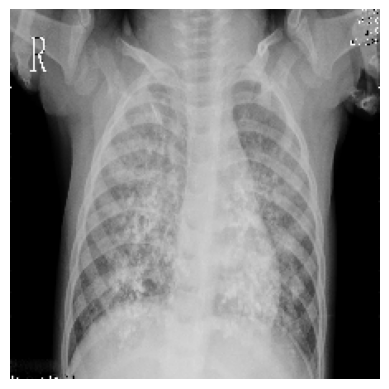

Prediction: Pneumonia


In [11]:
def predict_image(image_path, model, img_size=IMG_SIZE):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(img_size, img_size))
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0  
    img_array = np.expand_dims(img_array, axis=0) 

    # Predict the class of the image
    prediction = model.predict(img_array)

    # Display the image
    plt.imshow(img)
    plt.axis('off')  
    plt.show()

    return "Pneumonia" if prediction > 0.5 else "Normal"

sample_image_path = "/Users/pranithapadala/Desktop/DLProject-3/chest_xray/test/PNEUMONIA/person1609_bacteria_4239.jpeg"  
result = predict_image(sample_image_path, model)
print(f"Prediction: {result}")

